In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

# Constants
NUM_POSE_LANDMARKS = 19   
NUM_HAND_LANDMARKS = 21
NUM_NODES = NUM_POSE_LANDMARKS + NUM_HAND_LANDMARKS*2  # Total nodes in the graph
FEATURE_DIM = 3  # x, y coordinates + visibility

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features,dropout=0.5):
        super(GCNLayer, self).__init__()
        # self.linear = nn.Linear(in_features, out_features,bias=True)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        # x: (batch_size * seq_len, num_nodes, in_features)
        # adj: (num_nodes, num_nodes) - shared across all samples
        
        # Ensure adj is on the same device as x
        if adj.device != x.device:
            adj = adj.to(x.device)
            
        # Expand adj to match batch dimension
        batch_size_seq = x.size(0)
        adj_expanded = adj.unsqueeze(0).expand(batch_size_seq, -1, -1)
        
        # Graph convolution: first aggregate neighborhood features
        x = torch.bmm(adj_expanded, x)  # (batch_size * seq_len, num_nodes, in_features)
        
        # For Conv1d: input needs to be (batch, channels, length)
        # So we permute from (batch, nodes, features) to (batch, features, nodes)
        x = x.permute(0, 2, 1)  # -> (batch_size * seq_len, in_features, num_nodes)
        
        # Apply convolution
        x = self.conv(x)  # (batch_size * seq_len, out_features, num_nodes)
        
        # Permute back to original format
        x = x.permute(0, 2, 1)  # -> (batch_size * seq_len, num_nodes, out_features)
        
        x = F.gelu(x)
        x = self.dropout(x)
        return x

class GCNBiLSTM(nn.Module):
    def __init__(self, num_nodes=NUM_NODES, in_features=FEATURE_DIM, 
                 gcn_hidden=64, lstm_hidden=128, num_classes=10, 
                 num_gcn_layers=2, dropout=0.5, label_map=None):
        super(GCNBiLSTM, self).__init__()
        
        # Create multiple GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNLayer(in_features, gcn_hidden,dropout))
        
        for _ in range(num_gcn_layers - 1):
            self.gcn_layers.append(GCNLayer(gcn_hidden, gcn_hidden,dropout))
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_nodes * gcn_hidden, 
            hidden_size=lstm_hidden, 
            num_layers=2,
            batch_first=True, 
            bidirectional=True,
            dropout=dropout if num_gcn_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Output classification layers
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, lstm_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
        self.label_map = label_map
        self.num_nodes = num_nodes
        self.gcn_hidden = gcn_hidden

    def forward(self, x, adj):
        # x shape: (batch_size, seq_len, num_nodes * in_features)
        # Reshape to (batch_size, seq_len, num_nodes, in_features)
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.num_nodes, -1)
        
        # Process each time step through GCN
        gcn_outputs = []
        for t in range(seq_len):
            # Get current time step data
            curr_x = x[:, t, :, :]  # (batch_size, num_nodes, in_features)
            
            # Process through GCN layers
            for gcn_layer in self.gcn_layers:
                curr_x = gcn_layer(curr_x, adj)
                curr_x = self.dropout(curr_x)
            
            # Flatten node features
            # curr_x = curr_x.view(batch_size, -1)  # (batch_size, num_nodes * gcn_hidden)
            curr_x = curr_x.contiguous().view(batch_size, -1)
            gcn_outputs.append(curr_x)
        
        # Stack outputs to (batch_size, seq_len, num_nodes * gcn_hidden)
        gcn_out = torch.stack(gcn_outputs, dim=1)
        
        # Process through BiLSTM
        lstm_out, _ = self.lstm(gcn_out)  # (batch_size, seq_len, lstm_hidden * 2)
        
        # Apply attention mechanism
        attn_weights = self.attention(lstm_out).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(-1)  # (batch_size, seq_len, 1)
        
        # Weighted sum of LSTM outputs
        context = torch.sum(lstm_out * attn_weights, dim=1)  # (batch_size, lstm_hidden * 2)
        
        # Final classification
        output = self.classifier(context)
        
        return output
    
    def predict_label(self, x, adj):
        self.eval() 
        with torch.no_grad():
            logits = self.forward(x, adj)  # Forward pass
            pred_classes = torch.argmax(logits, dim=1)  # Get the predicted class (index)
            
            if self.label_map is not None:
                pred_labels = [self.label_map[int(idx)] for idx in pred_classes.cpu().numpy()]
                return pred_labels
            else:
                return pred_classes



class GraphSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


def parse_frame(frame,):
    keypoints = []
    for part in ['pose', 'left_hand', 'right_hand']:
        for landmark in frame.get(part, []):
            keypoints.extend([landmark['x'], landmark['y'], landmark['visibility']])
    return keypoints


def load_and_preprocess_data(data_dir, sequence_length=15):
    """
    Load and preprocess the JSON files into sequences.
    
    Args:
        data_dir: Directory containing the data
        sequence_length: Number of frames in each sequence
        
    Returns:
        sequences: array of shape (num_sequences, sequence_length, num_nodes * features)
        sequence_labels: array of class labels
        label_encoder: fitted LabelEncoder
    """
    frame_data = []
    raw_labels = []
    
    # Step 1: Collect all labels
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".json"):
                label = os.path.basename(os.path.dirname(os.path.join(root, file)))
                raw_labels.append(label)
    
    # Step 2: Fit label encoder
    encoder = LabelEncoder()
    encoder.fit(raw_labels)
    label_map = {label: int(encoder.transform([label])[0]) for label in set(raw_labels)}
    
    sequences = []
    sequence_labels = []

    # Step 3: Parse frames and assign encoded labels
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".json"):
                label = os.path.basename(os.path.dirname(os.path.join(root, file)))
                encoded_label = label_map[label]
                with open(os.path.join(root, file), 'r') as f:
                    frames = json.load(f)
                    features=[]
                    for frame in frames:
                        features.append(parse_frame(frame))
                        # frame_data.append([np.array(features), encoded_label])
                    sequences.append(np.stack(features))
                    sequence_labels.append(encoded_label)
    idx_to_label = {v: k for k, v in label_map.items()}
    label_map = idx_to_label
    del idx_to_label
    gc.collect()
    
    return np.array(sequences), np.array(sequence_labels), label_map


def create_adjacency_matrix():
    """Create the adjacency matrix for the graph."""

    pose_connections = [
        # Mouth
        (9,10),
        # Left Eyes
        (1,2),(2,3),(3,7),
        # Right Eyes
        (4,5),(5,6),(6,8),
        # Nose
        (0,4),(0,1),
        # Shoulders
        (11, 12),
        # Connect shoulders to hip
        (11, 17), (12, 18),
        # Connect hip points
        (17, 18),
        # Left arm
        (11, 13), (13, 15),
        # Right arm
        (12, 14), (14, 16)
    ]

    hand_connections = [
        # Thumb
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Index finger
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Middle finger
        (0, 9), (9, 10), (10, 11), (11, 12),
        # Ring finger
        (0, 13), (13, 14), (14, 15), (15, 16),
        # Pinky
        (0, 17), (17, 18), (18, 19), (19, 20),
        # Palm connections
        (5, 9), (9, 13), (13, 17)
    ]
    
    def create_adj_matrix(num_nodes, connections):
        adj_matrix = np.zeros((num_nodes, num_nodes))
        for i, j in connections:
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1
        # Add self-loops
        for i in range(num_nodes):
            adj_matrix[i, i] = 1
        return adj_matrix

    pose_adj_matrix = create_adj_matrix(NUM_POSE_LANDMARKS, pose_connections)
    left_hand_adj_matrix = create_adj_matrix(NUM_HAND_LANDMARKS, hand_connections)
    right_hand_adj_matrix = create_adj_matrix(NUM_HAND_LANDMARKS, hand_connections)

    # Calculate the total number of nodes
    total_nodes = NUM_POSE_LANDMARKS + NUM_HAND_LANDMARKS + NUM_HAND_LANDMARKS

    # Initialize a global adjacency matrix
    global_adj_matrix = np.zeros((total_nodes, total_nodes))
    
    # start_pose = NUM_FACE_LANDMARKS
    start_pose=0
    end_pose = start_pose + NUM_POSE_LANDMARKS
    global_adj_matrix[start_pose:end_pose, start_pose:end_pose] = pose_adj_matrix
    
    start_lh = end_pose
    end_lh = start_lh + NUM_HAND_LANDMARKS
    global_adj_matrix[start_lh:end_lh, start_lh:end_lh] = left_hand_adj_matrix
    
    start_rh = end_lh
    end_rh = start_rh + NUM_HAND_LANDMARKS
    global_adj_matrix[start_rh:end_rh, start_rh:end_rh] = right_hand_adj_matrix
    
    # Connect pose to hands
    pose_hand_connections = [
        (start_pose + 15, start_lh),  # Left hand wrist to left hand base
        (start_pose + 16, start_rh),  # Right hand wrist to right hand base
    ]
    for i, j in pose_hand_connections:
        global_adj_matrix[i, j] = 1
        global_adj_matrix[j, i] = 1

    # Normalize adjacency matrix (D^-0.5 * A * D^-0.5)
    # Add identity matrix to include self-connections
    adj_matrix = global_adj_matrix + np.eye(total_nodes)
    
    # Calculate degree matrix
    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    
    # D^-0.5
    deg_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))
    
    # Normalized adjacency matrix
    normalized_adj_matrix = deg_inv_sqrt @ adj_matrix @ deg_inv_sqrt

    return torch.FloatTensor(normalized_adj_matrix)


def train_model(model, train_loader, val_loader, adj_matrix, num_epochs=50, lr=0.001, 
               weight_decay=1e-5, patience=10, model_save_path='best_model.pt'):
    """
    Train the GCNBiLSTM model
    
    Args:
        model: GCNBiLSTM model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        adj_matrix: Normalized adjacency matrix
        num_epochs: Number of training epochs
        lr: Learning rate
        weight_decay: Weight decay factor
        patience: Early stopping patience
        model_save_path: Path to save best model
        
    Returns:
        model: Trained model
        train_losses: List of training losses
        val_losses: List of validation losses
        train_accs: List of training accuracies
        val_accs: List of validation accuracies
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    adj_matrix = adj_matrix.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, adj_matrix)
            
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optional: gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs, adj_matrix)
                
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save only the model state dict
            torch.save({'model_state_dict':model.state_dict(),'label_map':model.label_map}, model_save_path)
            
            
            early_stop_counter = 0
            print(f"Saved best model to {model_save_path}")
        else:
            early_stop_counter += 1
            
        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    checkpoint = torch.load(model_save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.label_map = checkpoint['label_map']
    return model, train_losses, val_losses, train_accs, val_accs


def evaluate_model(model, test_loader, adj_matrix):
    """
    Evaluate the model on test data
    
    Args:
        model: Trained GCNBiLSTM model
        test_loader: DataLoader for test data
        adj_matrix: Normalized adjacency matrix
        
    Returns:
        test_acc: Test accuracy
        predictions: Predicted labels
        true_labels: True labels
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    adj_matrix = adj_matrix.to(device)
    
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, adj_matrix)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    return test_acc, np.array(all_preds), np.array(all_targets)


def plot_results(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training and validation metrics
    
    Args:
        train_losses: List of training losses
        val_losses: List of validation losses
        train_accs: List of training accuracies
        val_accs: List of validation accuracies
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


def main():
    torch.serialization.add_safe_globals([LabelEncoder])
    # Set random seeds for reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    # 1. Load and preprocess data
    data_dir = "data"  # Update with your data directory
    test_dir = "test_data"
    sequences, sequence_labels, label_map = load_and_preprocess_data(data_dir)
    
    print(f"Loaded {len(sequences)} sequences with shape {sequences.shape}")
    print(f'Sequence Label {len(sequence_labels)}')
    print(f"Number of classes: {len(label_map)}")
    
    # 2. Create adjacency matrix

    adj_matrix = create_adjacency_matrix()
    print(f'Unique Label : {len(np.unique(sequence_labels))}')
    X_train,X_val,y_train,y_val = train_test_split(
        sequences, sequence_labels, test_size=0.4, random_state=SEED, stratify=sequence_labels
    )
    print(f'Unique Train : {len(np.unique(y_train))}')
    print(f'Unique Val : {len(np.unique(y_val))}')
    X_val,X_test,y_val,y_test = train_test_split(
        X_val, y_val, test_size=0.5, random_state=SEED, stratify=y_val
    )
    print(f'Unique Train : {len(np.unique(y_train))}')
    print(f'Unique Test : {len(np.unique(y_test))}')
    # X_test,y_test, _ = load_and_preprocess_data(test_dir)


    # 4. Create datasets and dataloaders
    train_dataset = GraphSequenceDataset(X_train, y_train)
    val_dataset = GraphSequenceDataset(X_val, y_val)
    test_dataset = GraphSequenceDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 5. Create and train the model
    num_classes = len(label_map)
    model = GCNBiLSTM(
        num_nodes=NUM_NODES,
        in_features=FEATURE_DIM,
        gcn_hidden=256,
        lstm_hidden=512,
        num_classes=num_classes,
        num_gcn_layers=2,
        dropout=0.3,
        label_map=label_map
    )
    
    # 6. Train the model
    trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, adj_matrix, 
        num_epochs=100, lr=0.001, weight_decay=5e-4, 
        patience=15, model_save_path='best_gcn_bilstm_model.pt'
    )
    
    # 7. Evaluate the model
    test_acc, predictions, true_labels = evaluate_model(trained_model, test_loader, adj_matrix)
    
    # 8. Plot results
    plot_results(train_losses, val_losses, train_accs, val_accs)
    
    # 9. Print classification report
    
    
    print("\nClassification Report:")
    actual_classes = np.unique(true_labels)
    print(actual_classes)
    class_names = [label_map[int(idx)] for idx in actual_classes]
    print(classification_report(true_labels, predictions, target_names=class_names))
    
    # 10. Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


Loaded 1722 sequences with shape (1722, 3, 183)
Sequence Label 1722
Number of classes: 25
Unique Label : 25
Unique Train : 25
Unique Val : 25
Unique Train : 25
Unique Test : 25
Using device: cuda


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 12.44it/s, loss=2.88, acc=13.6]


Epoch 1/100 - Train Loss: 2.8834, Train Acc: 13.55% - Val Loss: 2.5057, Val Acc: 16.28%
Saved best model to best_gcn_bilstm_model.pt


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.53it/s, loss=2.19, acc=25.7]


Epoch 2/100 - Train Loss: 2.1939, Train Acc: 25.65% - Val Loss: 2.1387, Val Acc: 28.78%
Saved best model to best_gcn_bilstm_model.pt


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:04<00:00,  7.52it/s, loss=1.83, acc=35.4]


Epoch 3/100 - Train Loss: 1.8253, Train Acc: 35.43% - Val Loss: 1.8384, Val Acc: 36.34%
Saved best model to best_gcn_bilstm_model.pt


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:04<00:00,  7.19it/s, loss=1.6, acc=43.7] 


Epoch 4/100 - Train Loss: 1.5995, Train Acc: 43.66% - Val Loss: 1.8402, Val Acc: 39.83%


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:04<00:00,  7.88it/s, loss=1.52, acc=47]  


Epoch 5/100 - Train Loss: 1.5159, Train Acc: 47.05% - Val Loss: 1.4667, Val Acc: 52.62%
Saved best model to best_gcn_bilstm_model.pt


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:03<00:00,  8.37it/s, loss=1.31, acc=53.3]


Epoch 6/100 - Train Loss: 1.3067, Train Acc: 53.34% - Val Loss: 1.4878, Val Acc: 49.71%


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:03<00:00,  9.04it/s, loss=1.28, acc=55.6]


Epoch 7/100 - Train Loss: 1.2785, Train Acc: 55.57% - Val Loss: 1.5308, Val Acc: 47.38%


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:04<00:00,  7.60it/s, loss=1.3, acc=56.1] 


Epoch 8/100 - Train Loss: 1.3050, Train Acc: 56.05% - Val Loss: 1.3571, Val Acc: 56.10%
Saved best model to best_gcn_bilstm_model.pt


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:06<00:00,  5.17it/s, loss=1.2, acc=59.9] 


Epoch 9/100 - Train Loss: 1.2009, Train Acc: 59.92% - Val Loss: 1.2675, Val Acc: 56.40%
Saved best model to best_gcn_bilstm_model.pt


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:06<00:00,  5.02it/s, loss=1.05, acc=63.5]


Epoch 10/100 - Train Loss: 1.0525, Train Acc: 63.50% - Val Loss: 1.1884, Val Acc: 59.01%
Saved best model to best_gcn_bilstm_model.pt


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:06<00:00,  5.47it/s, loss=1.07, acc=61.3] 


Epoch 11/100 - Train Loss: 1.0655, Train Acc: 61.28% - Val Loss: 1.0779, Val Acc: 65.12%
Saved best model to best_gcn_bilstm_model.pt


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:31<00:00,  1.04it/s, loss=0.992, acc=64.9]


Epoch 12/100 - Train Loss: 0.9924, Train Acc: 64.86% - Val Loss: 1.0683, Val Acc: 63.95%
Saved best model to best_gcn_bilstm_model.pt


Epoch 13/100 [Train]: 100%|██████████| 33/33 [01:26<00:00,  2.63s/it, loss=0.921, acc=69.1]


Epoch 13/100 - Train Loss: 0.9210, Train Acc: 69.12% - Val Loss: 1.1111, Val Acc: 63.95%


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 19.64it/s, loss=0.932, acc=68.4]


Epoch 14/100 - Train Loss: 0.9320, Train Acc: 68.44% - Val Loss: 1.0514, Val Acc: 65.70%
Saved best model to best_gcn_bilstm_model.pt


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.49it/s, loss=0.851, acc=70.1]


Epoch 15/100 - Train Loss: 0.8515, Train Acc: 70.09% - Val Loss: 1.1069, Val Acc: 65.70%


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.72it/s, loss=0.811, acc=73.1]


Epoch 16/100 - Train Loss: 0.8106, Train Acc: 73.09% - Val Loss: 0.9814, Val Acc: 69.77%
Saved best model to best_gcn_bilstm_model.pt


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.43it/s, loss=0.837, acc=72.4]


Epoch 17/100 - Train Loss: 0.8372, Train Acc: 72.41% - Val Loss: 0.9305, Val Acc: 72.38%
Saved best model to best_gcn_bilstm_model.pt


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.63it/s, loss=0.709, acc=77.4]


Epoch 18/100 - Train Loss: 0.7087, Train Acc: 77.44% - Val Loss: 0.7989, Val Acc: 75.87%
Saved best model to best_gcn_bilstm_model.pt


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.18it/s, loss=0.7, acc=75]    


Epoch 19/100 - Train Loss: 0.6997, Train Acc: 75.02% - Val Loss: 0.9172, Val Acc: 74.71%


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.86it/s, loss=0.719, acc=75.6]


Epoch 20/100 - Train Loss: 0.7190, Train Acc: 75.61% - Val Loss: 0.8643, Val Acc: 74.42%


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.58it/s, loss=0.656, acc=77.9]


Epoch 21/100 - Train Loss: 0.6557, Train Acc: 77.93% - Val Loss: 0.8275, Val Acc: 75.00%


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.56it/s, loss=0.588, acc=80.4]


Epoch 22/100 - Train Loss: 0.5877, Train Acc: 80.45% - Val Loss: 0.7743, Val Acc: 79.94%
Saved best model to best_gcn_bilstm_model.pt


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.16it/s, loss=0.58, acc=81]   


Epoch 23/100 - Train Loss: 0.5797, Train Acc: 81.03% - Val Loss: 0.8612, Val Acc: 76.74%


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.83it/s, loss=0.593, acc=79.5]


Epoch 24/100 - Train Loss: 0.5932, Train Acc: 79.48% - Val Loss: 0.8592, Val Acc: 78.20%


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.35it/s, loss=0.615, acc=79]  


Epoch 25/100 - Train Loss: 0.6148, Train Acc: 78.99% - Val Loss: 0.7635, Val Acc: 75.58%
Saved best model to best_gcn_bilstm_model.pt


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.19it/s, loss=0.581, acc=80.2]


Epoch 26/100 - Train Loss: 0.5806, Train Acc: 80.15% - Val Loss: 0.7917, Val Acc: 78.49%


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.84it/s, loss=0.516, acc=82.7]


Epoch 27/100 - Train Loss: 0.5165, Train Acc: 82.67% - Val Loss: 0.7023, Val Acc: 78.49%
Saved best model to best_gcn_bilstm_model.pt


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.49it/s, loss=0.505, acc=82.2]


Epoch 28/100 - Train Loss: 0.5052, Train Acc: 82.19% - Val Loss: 0.8116, Val Acc: 77.33%


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.27it/s, loss=0.46, acc=83.4] 


Epoch 29/100 - Train Loss: 0.4597, Train Acc: 83.45% - Val Loss: 0.6462, Val Acc: 83.72%
Saved best model to best_gcn_bilstm_model.pt


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.72it/s, loss=0.46, acc=83]   


Epoch 30/100 - Train Loss: 0.4602, Train Acc: 82.96% - Val Loss: 0.7448, Val Acc: 79.07%


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.05it/s, loss=0.428, acc=86.4]


Epoch 31/100 - Train Loss: 0.4275, Train Acc: 86.35% - Val Loss: 0.6706, Val Acc: 82.56%


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.03it/s, loss=0.431, acc=85.2]


Epoch 32/100 - Train Loss: 0.4309, Train Acc: 85.19% - Val Loss: 0.6400, Val Acc: 83.14%
Saved best model to best_gcn_bilstm_model.pt


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.30it/s, loss=0.483, acc=83.6]


Epoch 33/100 - Train Loss: 0.4826, Train Acc: 83.64% - Val Loss: 0.6759, Val Acc: 80.52%


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.57it/s, loss=0.399, acc=87.1]


Epoch 34/100 - Train Loss: 0.3987, Train Acc: 87.12% - Val Loss: 0.6022, Val Acc: 81.40%
Saved best model to best_gcn_bilstm_model.pt


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.57it/s, loss=0.416, acc=85.2]


Epoch 35/100 - Train Loss: 0.4164, Train Acc: 85.19% - Val Loss: 0.7667, Val Acc: 80.52%


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 19.88it/s, loss=0.454, acc=84.7]


Epoch 36/100 - Train Loss: 0.4540, Train Acc: 84.70% - Val Loss: 0.7730, Val Acc: 77.03%


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 20.54it/s, loss=0.382, acc=86.4]


Epoch 37/100 - Train Loss: 0.3822, Train Acc: 86.45% - Val Loss: 0.6633, Val Acc: 80.52%


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 20.22it/s, loss=0.413, acc=84.4]


Epoch 38/100 - Train Loss: 0.4128, Train Acc: 84.41% - Val Loss: 0.6207, Val Acc: 84.01%


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.16it/s, loss=0.423, acc=85.1]


Epoch 39/100 - Train Loss: 0.4227, Train Acc: 85.09% - Val Loss: 0.6141, Val Acc: 82.85%


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.69it/s, loss=0.39, acc=87.1] 


Epoch 40/100 - Train Loss: 0.3904, Train Acc: 87.12% - Val Loss: 0.6777, Val Acc: 80.81%


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.02it/s, loss=0.346, acc=89.7]


Epoch 41/100 - Train Loss: 0.3457, Train Acc: 89.74% - Val Loss: 0.5309, Val Acc: 86.92%
Saved best model to best_gcn_bilstm_model.pt


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.32it/s, loss=0.211, acc=92.4]


Epoch 42/100 - Train Loss: 0.2111, Train Acc: 92.35% - Val Loss: 0.5283, Val Acc: 86.34%
Saved best model to best_gcn_bilstm_model.pt


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.92it/s, loss=0.203, acc=93]  


Epoch 43/100 - Train Loss: 0.2026, Train Acc: 93.03% - Val Loss: 0.5977, Val Acc: 83.43%


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.66it/s, loss=0.242, acc=91.4]


Epoch 44/100 - Train Loss: 0.2419, Train Acc: 91.38% - Val Loss: 0.5118, Val Acc: 86.92%
Saved best model to best_gcn_bilstm_model.pt


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 19.46it/s, loss=0.195, acc=93.8]


Epoch 45/100 - Train Loss: 0.1950, Train Acc: 93.80% - Val Loss: 0.5158, Val Acc: 86.92%


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.45it/s, loss=0.192, acc=92.8]


Epoch 46/100 - Train Loss: 0.1923, Train Acc: 92.84% - Val Loss: 0.5536, Val Acc: 87.21%


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.86it/s, loss=0.205, acc=93]  


Epoch 47/100 - Train Loss: 0.2050, Train Acc: 93.03% - Val Loss: 0.5827, Val Acc: 84.88%


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.10it/s, loss=0.163, acc=93.7]


Epoch 48/100 - Train Loss: 0.1626, Train Acc: 93.71% - Val Loss: 0.5764, Val Acc: 87.21%


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.04it/s, loss=0.166, acc=93.5]


Epoch 49/100 - Train Loss: 0.1660, Train Acc: 93.51% - Val Loss: 0.6098, Val Acc: 85.17%


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.96it/s, loss=0.191, acc=93.2]


Epoch 50/100 - Train Loss: 0.1913, Train Acc: 93.22% - Val Loss: 0.5244, Val Acc: 87.79%


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.14it/s, loss=0.143, acc=94.7]


Epoch 51/100 - Train Loss: 0.1431, Train Acc: 94.68% - Val Loss: 0.5132, Val Acc: 87.21%


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.51it/s, loss=0.13, acc=95.1] 


Epoch 52/100 - Train Loss: 0.1302, Train Acc: 95.06% - Val Loss: 0.4756, Val Acc: 89.53%
Saved best model to best_gcn_bilstm_model.pt


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.42it/s, loss=0.14, acc=95.3] 


Epoch 53/100 - Train Loss: 0.1396, Train Acc: 95.26% - Val Loss: 0.5170, Val Acc: 88.37%


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.88it/s, loss=0.119, acc=96.1]


Epoch 54/100 - Train Loss: 0.1188, Train Acc: 96.13% - Val Loss: 0.4921, Val Acc: 88.95%


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.29it/s, loss=0.102, acc=97]   


Epoch 55/100 - Train Loss: 0.1016, Train Acc: 97.00% - Val Loss: 0.5245, Val Acc: 88.37%


Epoch 56/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.92it/s, loss=0.0956, acc=97.1]


Epoch 56/100 - Train Loss: 0.0956, Train Acc: 97.10% - Val Loss: 0.5183, Val Acc: 88.37%


Epoch 57/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.80it/s, loss=0.104, acc=97.1] 


Epoch 57/100 - Train Loss: 0.1044, Train Acc: 97.10% - Val Loss: 0.5376, Val Acc: 88.95%


Epoch 58/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.31it/s, loss=0.113, acc=95.7]


Epoch 58/100 - Train Loss: 0.1135, Train Acc: 95.74% - Val Loss: 0.5039, Val Acc: 90.12%


Epoch 59/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.36it/s, loss=0.094, acc=97]   


Epoch 59/100 - Train Loss: 0.0940, Train Acc: 97.00% - Val Loss: 0.4994, Val Acc: 89.24%


Epoch 60/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.46it/s, loss=0.0919, acc=96.5]


Epoch 60/100 - Train Loss: 0.0919, Train Acc: 96.52% - Val Loss: 0.5020, Val Acc: 88.37%


Epoch 61/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.30it/s, loss=0.0873, acc=97.4]


Epoch 61/100 - Train Loss: 0.0873, Train Acc: 97.39% - Val Loss: 0.5262, Val Acc: 89.83%


Epoch 62/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.03it/s, loss=0.0792, acc=97.7]


Epoch 62/100 - Train Loss: 0.0792, Train Acc: 97.68% - Val Loss: 0.5254, Val Acc: 88.95%


Epoch 63/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.82it/s, loss=0.08, acc=97.2]  


Epoch 63/100 - Train Loss: 0.0800, Train Acc: 97.19% - Val Loss: 0.5160, Val Acc: 88.95%


Epoch 64/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.53it/s, loss=0.0795, acc=97.6]


Epoch 64/100 - Train Loss: 0.0795, Train Acc: 97.58% - Val Loss: 0.5122, Val Acc: 89.53%


Epoch 65/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.27it/s, loss=0.0657, acc=98.2]


Epoch 65/100 - Train Loss: 0.0657, Train Acc: 98.16% - Val Loss: 0.5274, Val Acc: 88.66%


Epoch 66/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.75it/s, loss=0.0649, acc=98.4]


Epoch 66/100 - Train Loss: 0.0649, Train Acc: 98.35% - Val Loss: 0.5218, Val Acc: 89.53%


Epoch 67/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.60it/s, loss=0.0701, acc=97.9]


Epoch 67/100 - Train Loss: 0.0701, Train Acc: 97.87% - Val Loss: 0.5065, Val Acc: 89.53%
Early stopping triggered after 67 epochs
Test Accuracy: 89.57%


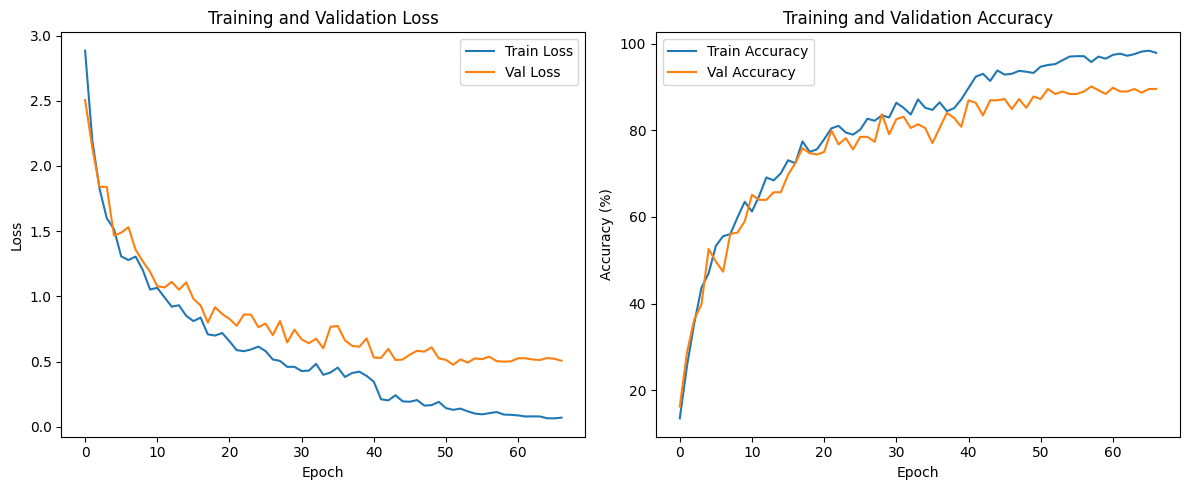


Classification Report:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
               precision    recall  f1-score   support

         baca       0.77      0.83      0.80        12
        bantu       0.90      0.82      0.86        11
        bapak       0.92      1.00      0.96        12
buangairkecil       1.00      0.83      0.91         6
         buat       0.93      1.00      0.96        13
         halo       1.00      1.00      1.00        18
          ibu       1.00      1.00      1.00         4
         kamu       0.86      0.63      0.73        19
         maaf       1.00      1.00      1.00        18
        makan       0.93      0.93      0.93        14
          mau       1.00      1.00      1.00        17
         nama       0.80      0.67      0.73        18
         pagi       1.00      0.95      0.97        20
        paham       0.95      1.00      0.98        20
        sakit       1.00      1.00      1.00         3
    sama-sama    

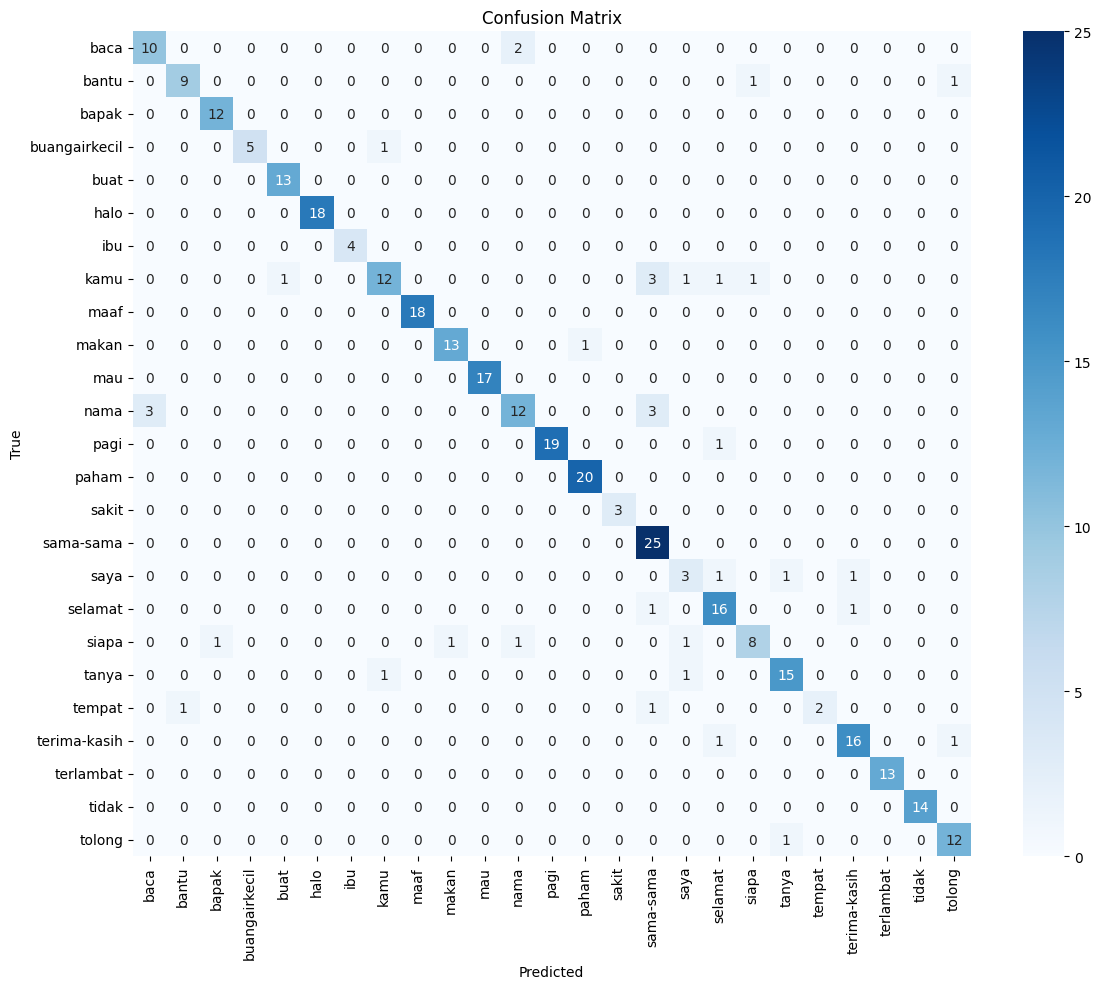

In [2]:
main()